# WEEK6 FINAL PROJECT

This is an augmenting notebook where I try to use transfer learning of MobileNet.


In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [1]:
import os, cv2, random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color

import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread


from keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet


import keras
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers import BatchNormalization
from keras.models import Model
from keras import optimizers

from keras.callbacks import ModelCheckpoint, EarlyStopping



In [ ]:
DATA_PATH = "kaggle"

INPUT_PATH = os.path.join(DATA_PATH, "input/state-farm-distracted-driver-detection")
IMAGES_PATH = os.path.join(INPUT_PATH, "imgs")
TEST_DIR = os.path.join(IMAGES_PATH, "test")
TRAIN_DIR = os.path.join(IMAGES_PATH, "train")

BASE_MODEL_PATH = os.path.join(DATA_PATH, "working", "model")

MODEL_PATH = os.path.join(BASE_MODEL_PATH, "resnet50")
OUTPUT_CSV_FILES_DIR = os.path.join(DATA_PATH, "working", "output_csv_files")
INPUT_CSV_FILES_DIR = os.path.join(DATA_PATH, "working", "input_csv_files")

if not os.path.exists(INPUT_CSV_FILES_DIR):
    os.makedirs(INPUT_CSV_FILES_DIR)
    print(f"Input CSV path created {INPUT_CSV_FILES_DIR}")
    
if not os.path.exists(OUTPUT_CSV_FILES_DIR):
    os.makedirs(OUTPUT_CSV_FILES_DIR)
    print(f"Output CSV path created {OUTPUT_CSV_FILES_DIR}")

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    print(f"Model path created {MODEL_PATH}")

In [4]:
driver_details = pd.read_csv(os.path.join(INPUT_PATH, "driver_imgs_list.csv"),na_values='na')
print(driver_details.head(5))

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [ ]:
## Get all the images

train_image = []
image_label = []


for i in range(10):
    imgs = os.listdir(os.path.join(TRAIN_DIR, "c"+str(i)))
    for j in range(len(imgs)):
        img_name = os.path.join(TRAIN_DIR, "c"+str(i), imgs[j])
        img = cv2.imread(img_name)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)


In [8]:
## Split the data into training and validation based on driver

driv_selected = ['p050', 'p015', 'p022', 'p056']

X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

18732 3692
18732 3692


In [9]:
## Convert images to nparray. Encode/categorize the Y

X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print (X_train.shape)

(18732, 224, 224, 3)


# Model

Let us use the mobilenet model and discard the top layer.  On top of this model let us add a softmax layer which will predict the probability of the 10 possible classes for the image.

In [5]:
base_model = MobileNet(weights='imagenet', include_top=False)

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

preds = Dense(10,activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, None, None, 32) │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, None, None, 32) │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, None, None, 32) │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, None, None, 64) │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, None, None, 64) │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, None, None,     │         8,192 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, None, None,     │         1,152 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,239,114 (12.36 MB)

 Trainable params: 3,217,226 (12.27 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [7]:
from keras import optimizers  

sgd = optimizers.SGD(learning_rate = 0.005)

model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])


In [13]:
filepath = os.path.join(MODEL_PATH,'mobilenet_sgd_nolayers.keras')
checkpointer = ModelCheckpoint(filepath, verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

datagen = ImageDataGenerator(height_shift_range=0.5, width_shift_range=0.5, zoom_range=0.5, rotation_range=30)

data_generator = datagen.flow(X_train, y_train, batch_size = 64)

mobilenet_model = model.fit(data_generator, steps_per_epoch=int(len(X_train)/64), callbacks=[checkpointer, earlystopper], epochs=25, verbose=1, validation_data=(X_test, y_test))


Epoch 1/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2447 - loss: 2.1706
Epoch 1: val_loss improved from inf to 1.12510, saving model to mobilenet_sgd_nolayers.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 664s 2s/step - accuracy: 0.2451 - loss: 2.1694 - val_accuracy: 0.6479 - val_loss: 1.1251
Epoch 2/25
  1/292 ━━━━━━━━━━━━━━━━━━━━ 11:31 2s/step - accuracy: 0.5469 - loss: 1.2764

2024-04-21 15:55:40.873533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 2: val_loss did not improve from 1.12510
292/292 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.5469 - loss: 1.2764 - val_accuracy: 0.6438 - val_loss: 1.1311
Epoch 3/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6299 - loss: 1.1557
Epoch 3: val_loss improved from 1.12510 to 0.71683, saving model to mobilenet_sgd_nolayers.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 660s 2s/step - accuracy: 0.6300 - loss: 1.1553 - val_accuracy: 0.7419 - val_loss: 0.7168
Epoch 4/25
  1/292 ━━━━━━━━━━━━━━━━━━━━ 11:40 2s/step - accuracy: 0.7344 - loss: 0.8708

2024-04-21 16:06:58.869091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_loss improved from 0.71683 to 0.70341, saving model to mobilenet_sgd_nolayers.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.7344 - loss: 0.8708 - val_accuracy: 0.7478 - val_loss: 0.7034
Epoch 5/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7235 - loss: 0.8320
Epoch 5: val_loss improved from 0.70341 to 0.58084, saving model to mobilenet_sgd_nolayers.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 658s 2s/step - accuracy: 0.7236 - loss: 0.8318 - val_accuracy: 0.8036 - val_loss: 0.5808
Epoch 6/25
  1/292 ━━━━━━━━━━━━━━━━━━━━ 11:37 2s/step - accuracy: 0.6406 - loss: 0.9418

2024-04-21 16:18:14.061869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 6: val_loss improved from 0.58084 to 0.57627, saving model to mobilenet_sgd_nolayers.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.6406 - loss: 0.9418 - val_accuracy: 0.8101 - val_loss: 0.5763
Epoch 7/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7706 - loss: 0.6985
Epoch 7: val_loss improved from 0.57627 to 0.54740, saving model to mobilenet_sgd_nolayers.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 639s 2s/step - accuracy: 0.7706 - loss: 0.6984 - val_accuracy: 0.8277 - val_loss: 0.5474
Epoch 8/25
  1/292 ━━━━━━━━━━━━━━━━━━━━ 10:51 2s/step - accuracy: 0.9062 - loss: 0.4745

2024-04-21 16:29:10.484095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 8: val_loss did not improve from 0.54740
292/292 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.9062 - loss: 0.4745 - val_accuracy: 0.8223 - val_loss: 0.5526
Epoch 9/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7991 - loss: 0.6109
Epoch 9: val_loss improved from 0.54740 to 0.54524, saving model to mobilenet_sgd_nolayers.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 658s 2s/step - accuracy: 0.7991 - loss: 0.6109 - val_accuracy: 0.8315 - val_loss: 0.5452
Epoch 10/25
  1/292 ━━━━━━━━━━━━━━━━━━━━ 11:59 2s/step - accuracy: 0.8906 - loss: 0.4275

2024-04-21 16:40:26.339429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 10: val_loss improved from 0.54524 to 0.54431, saving model to mobilenet_sgd_nolayers.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.8906 - loss: 0.4275 - val_accuracy: 0.8299 - val_loss: 0.5443
Epoch 11/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8222 - loss: 0.5489
Epoch 11: val_loss improved from 0.54431 to 0.53975, saving model to mobilenet_sgd_nolayers.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 640s 2s/step - accuracy: 0.8222 - loss: 0.5488 - val_accuracy: 0.8421 - val_loss: 0.5398
Epoch 12/25
  1/292 ━━━━━━━━━━━━━━━━━━━━ 10:52 2s/step - accuracy: 0.7500 - loss: 0.7011

2024-04-21 16:51:24.192979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 12: val_loss did not improve from 0.53975
292/292 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.7500 - loss: 0.7011 - val_accuracy: 0.8418 - val_loss: 0.5420
Epoch 13/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8342 - loss: 0.5007
Epoch 13: val_loss improved from 0.53975 to 0.51558, saving model to mobilenet_sgd_nolayers.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 641s 2s/step - accuracy: 0.8342 - loss: 0.5007 - val_accuracy: 0.8445 - val_loss: 0.5156
Epoch 14/25
  1/292 ━━━━━━━━━━━━━━━━━━━━ 10:59 2s/step - accuracy: 0.8594 - loss: 0.4683

2024-04-21 17:02:22.335872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 14: val_loss did not improve from 0.51558
292/292 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.8594 - loss: 0.4683 - val_accuracy: 0.8402 - val_loss: 0.5249
Epoch 15/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8448 - loss: 0.4767
Epoch 15: val_loss did not improve from 0.51558
292/292 ━━━━━━━━━━━━━━━━━━━━ 646s 2s/step - accuracy: 0.8448 - loss: 0.4767 - val_accuracy: 0.8483 - val_loss: 0.5534
Epoch 16/25
  1/292 ━━━━━━━━━━━━━━━━━━━━ 11:02 2s/step - accuracy: 0.8750 - loss: 0.4227

2024-04-21 17:13:25.429366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 16: val_loss did not improve from 0.51558
292/292 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.8750 - loss: 0.4227 - val_accuracy: 0.8472 - val_loss: 0.5584
Epoch 17/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8576 - loss: 0.4394
Epoch 17: val_loss did not improve from 0.51558
292/292 ━━━━━━━━━━━━━━━━━━━━ 659s 2s/step - accuracy: 0.8576 - loss: 0.4394 - val_accuracy: 0.8462 - val_loss: 0.5676
Epoch 18/25
  1/292 ━━━━━━━━━━━━━━━━━━━━ 11:02 2s/step - accuracy: 0.8125 - loss: 0.4594

2024-04-21 17:24:42.463575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 18: val_loss did not improve from 0.51558
292/292 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.8125 - loss: 0.4594 - val_accuracy: 0.8456 - val_loss: 0.5645
Epoch 19/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8634 - loss: 0.4064
Epoch 19: val_loss improved from 0.51558 to 0.48852, saving model to mobilenet_sgd_nolayers.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 645s 2s/step - accuracy: 0.8634 - loss: 0.4064 - val_accuracy: 0.8651 - val_loss: 0.4885
Epoch 20/25
  1/292 ━━━━━━━━━━━━━━━━━━━━ 11:45 2s/step - accuracy: 0.8906 - loss: 0.4087

2024-04-21 17:35:45.608152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 20: val_loss improved from 0.48852 to 0.48797, saving model to mobilenet_sgd_nolayers.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.8906 - loss: 0.4087 - val_accuracy: 0.8640 - val_loss: 0.4880
Epoch 21/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8761 - loss: 0.3815
Epoch 21: val_loss did not improve from 0.48797
292/292 ━━━━━━━━━━━━━━━━━━━━ 660s 2s/step - accuracy: 0.8761 - loss: 0.3815 - val_accuracy: 0.8532 - val_loss: 0.4980
Epoch 22/25
  1/292 ━━━━━━━━━━━━━━━━━━━━ 11:02 2s/step - accuracy: 0.8594 - loss: 0.4900

2024-04-21 17:47:03.374522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 22: val_loss did not improve from 0.48797
292/292 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.8594 - loss: 0.4900 - val_accuracy: 0.8527 - val_loss: 0.4983
Epoch 23/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8816 - loss: 0.3670
Epoch 23: val_loss improved from 0.48797 to 0.48496, saving model to mobilenet_sgd_nolayers.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 657s 2s/step - accuracy: 0.8816 - loss: 0.3670 - val_accuracy: 0.8621 - val_loss: 0.4850
Epoch 24/25
  1/292 ━━━━━━━━━━━━━━━━━━━━ 11:06 2s/step - accuracy: 0.9062 - loss: 0.2634

2024-04-21 17:58:19.129064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 24: val_loss did not improve from 0.48496
292/292 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.9062 - loss: 0.2634 - val_accuracy: 0.8611 - val_loss: 0.4899
Epoch 25/25
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8863 - loss: 0.3504
Epoch 25: val_loss did not improve from 0.48496
292/292 ━━━━━━━━━━━━━━━━━━━━ 647s 2s/step - accuracy: 0.8863 - loss: 0.3504 - val_accuracy: 0.8415 - val_loss: 0.5644


# TEST

Image number: 0
Image number: 1
Image number: 2
Image number: 3
Image number: 4
Image number: 5
Image number: 6
Image number: 7
Image number: 8
Image number: 9
Image number: 10
Image number: 11
Image number: 12
Image number: 13
Image number: 14
Image number: 15
Image number: 16
Image number: 17
Image number: 18
Image number: 19


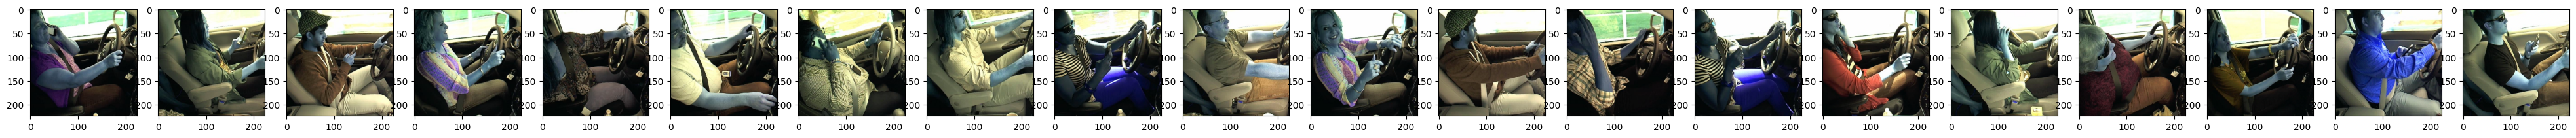

In [3]:
test_image = []
i = 0
fig, ax = plt.subplots(1, 20, figsize = (50,50 ))

files = os.listdir(TEST_DIR)
nums = np.random.randint(low=1, high=len(files), size=20)
for i in range(20):
    print ('Image number:',i)
    img = cv2.imread(os.path.join(TEST_DIR, files[nums[i]]))
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    
    ax[i].imshow(img,cmap = 'gray')
    plt.show

for i in range(len(files)):
    img = cv2.imread(os.path.join(TEST_DIR, +files[i]))
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    test_image.append(img)

In [8]:
#load the best model and predict
model.load_weights(filepath)

test_image = np.array(test_image).reshape(-1,224,224,3)
prediction = model.predict(test_image)

2492/2492 ━━━━━━━━━━━━━━━━━━━━ 340s 136ms/step


In [9]:
prediction.shape

(79726, 10)

In [20]:
tags = { 
    "C0": "safe driving",
    "C1": "texting - right",
    "C2": "talking on the phone - right",
    "C3": "texting - left",
    "C4": "talking on the phone - left",
    "C5": "operating the radio",
    "C6": "drinking",
    "C7": "reaching behind",
    "C8": "hair and makeup",
    "C9": "talking to passenger" 
}

In [ ]:
i = 0
fig, ax = plt.subplots(20, 1, figsize = (100,100))

for i in range(20):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'C'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(tags[predicted_class])
    plt.show


In [10]:
df = pd.DataFrame(columns=['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
for i in range(len(files)):
    new_row = {
        "img":files[i], 
        'c0':prediction[i][0],
        'c1':prediction[i][1],
        'c2':prediction[i][2],
        'c3':prediction[i][3],
        'c4':prediction[i][4],
        'c5':prediction[i][5],
        'c6':prediction[i][6],
        'c7':prediction[i][7],
        'c8':prediction[i][8],
        'c9':prediction[i][9]
    }
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
df.to_csv(os.path.join("csv_files","mobilenet_sgd_1.csv"),index=False)

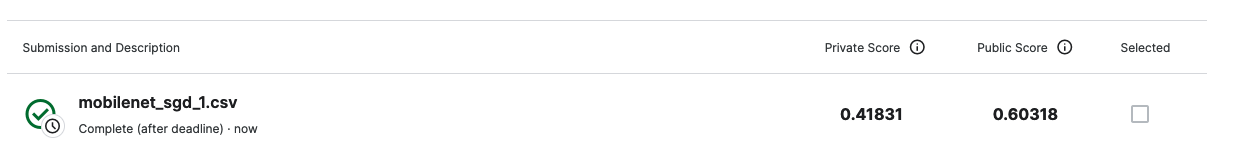

## Conclusion
Please check the main notebook for a combined conclusion